# Sandbox Jupyter Notebook for Source2Suffering

Modules needed that can be load with Jupyter Lab

- xarray
- cartopy
- openpyxl

Modules needed that can't be load with Jupyter Lab

- mapclassify 2.4.3
   - Provide in geopandas/0.12.2-foss-2022a
         - Works if we load geopandas from Jupyter Lab

---

Change path to current directory path

In [2]:
import os

notebook_path = os.getcwd()  # Current path
print("Directory of the notebook:", notebook_path)
notebook_path = notebook_path

scripts_dir = "/data/brussel/vo/000/bvo00012/vsc11137/source2suffering"
data_dir = scripts_dir+"/data/"

Directory of the notebook: /vscmnt/brussel_pixiu_data/_data_brussel/vo/000/bvo00012/vsc11137/source2suffering/sandbox


Libraries

In [3]:
#%%  ----------------------------------------------------------------
# import and path
# ----------------------------------------------------------------

import xarray as xr
import pickle as pk
import time
# from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import mapclassify as mc
from copy import deepcopy as cp
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy as cr
import geopandas as gpd
import sys
from operator import index
import numpy as np
import pandas as pd
from scipy import interpolate
from scipy import stats as sts
import regionmask as rm
import glob

sys.path.append(os.path.abspath(scripts_dir))

## Visualization of objects

exposure_peryear_perage_percountry_{extr}_{ISIMIP_run}.pkl

In [4]:
with open(data_dir+'{}/{}/exposure_peryear_perage_percountry_{}_{}.pkl'.format('pickles_v3','heatwavedarea','heatwavedarea',5), 'rb') as f:
            da_exposure_peryear_perage_percountry_strj_heatwavedarea_sim=pk.load(f)   

In [5]:
print(type(da_exposure_peryear_perage_percountry_strj_heatwavedarea_sim))
print(np.shape(da_exposure_peryear_perage_percountry_strj_heatwavedarea_sim))
print(da_exposure_peryear_perage_percountry_strj_heatwavedarea_sim)

<class 'xarray.core.dataarray.DataArray'>
(177, 154, 101, 21)
<xarray.DataArray (country: 177, time: 154, ages: 101, GMT: 21)>
array([[[[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]],

        [[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          

In [6]:
da_subset = da_exposure_peryear_perage_percountry_strj_heatwavedarea_sim.sel(country='Egypt')
non_nan_indices = np.where(~np.isnan(da_subset.values))
print(non_nan_indices)

(array([  0,   0,   0, ..., 153, 153, 153]), array([  0,   0,   0, ..., 100, 100, 100]), array([ 0,  1,  2, ..., 18, 19, 20]))


In [7]:
print(da_subset.sel(time=2030,ages=10,GMT=1))

<xarray.DataArray ()>
array(0.090036)
Coordinates:
    country  <U32 'Egypt'
    time     int64 2030
    ages     int64 10
    GMT      int64 1


In [8]:
da_values_all_times = da_subset.sel(time=slice(None))  # slice(None) sélectionne toutes les valeurs de la dimension time
y_values = da_values_all_times.sel(ages=10, GMT=20)

plt.plot(da_subset.sel(ages=10,GMT=20),y_values)
plt.show()
plt.savefig(scripts_dir+'/sandbox/figures/fig1.png')

exposure_trends{extr}

In [9]:
with open(data_dir+'{}/{}/lifetime_exposure_trends_regions.pkl'.format('pickles_v3','heatwavedarea'), 'rb') as f:
            ds_le_trends_regions=pk.load(f)   

In [10]:
ds_le_trends_regions

<xarray.Dataset>
Dimensions:                      (run: 12, GMT: 21, region: 46, year: 61,
                                  country: 177, basin: 220)
Coordinates:
  * region                       (region) int64 0 1 2 3 4 5 ... 41 42 43 44 45
  * country                      (country) int64 0 1 2 3 4 ... 173 174 175 176
  * basin                        (basin) int64 0 1 2 3 4 ... 221 222 223 224 225
  * run                          (run) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * GMT                          (GMT) int64 0 1 2 3 4 5 6 ... 15 16 17 18 19 20
  * year                         (year) int64 1960 1961 1962 ... 2018 2019 2020
Data variables:
    exposure_trend_ar6           (run, GMT, region, year) float64 nan ... nan
    mean_exposure_trend_ar6      (GMT, region, year) float64 nan nan ... nan nan
    exposure_trend_country       (run, GMT, country, year) float64 nan ... nan
    mean_exposure_trend_country  (GMT, country, year) float64 nan nan ... nan
    exposure_trend_basin         (run, GMT, basin, year) float64 nan nan ... nan
    mean_exposure_trend_basin    (GMT, basin, year) float64 nan nan ... nan nan

In [11]:
value = ds_le_trends_regions['exposure_trend_ar6'].sel(
    run=2,
    GMT=5,
    region=10,
    year=2020
)

print(value)

<xarray.DataArray 'exposure_trend_ar6' ()>
array(nan)
Coordinates:
    region   int64 10
    run      int64 2
    GMT      int64 5
    year     int64 2020


In [12]:
print(ds_le_trends_regions['exposure_trend_ar6'].sel(
    run=11,
    GMT=20,
    region=25,
))

<xarray.DataArray 'exposure_trend_ar6' (year: 61)>
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan])
Coordinates:
    region   int64 25
    run      int64 11
    GMT      int64 20
  * year     (year) int64 1960 1961 1962 1963 1964 ... 2016 2017 2018 2019 2020


In [13]:
# Vérifier si la variable 'exposure_trend_ar6' existe dans le dataset
if 'exposure_trend_ar6' in ds_le_trends_regions:

    # Créer un masque booléen où True indique que la valeur n'est pas NaN
    mask_non_nan = ds_le_trends_regions['exposure_trend_ar6'].notnull()

    # Vérifier s'il existe des valeurs non-NaN dans toutes les dimensions et coordonnées
    all_non_nan = mask_non_nan.all()

    # Afficher le résultat
    if all_non_nan:
        print("Toutes les coordonnées ont des valeurs non nulles et différentes de NaN.")
    else:
        print("Certaines coordonnées contiennent des valeurs NaN ou nulles.")
else:
    print("La variable 'exposure_trend_ar6' n'existe pas dans le dataset.")


Certaines coordonnées contiennent des valeurs NaN ou nulles.


da_regions

In [14]:
d_countries = pk.load(open(data_dir+'{}/country/country_info.pkl'.format('pickles_v3'), 'rb'))
df_countries = d_countries['info_pop']

In [15]:
da_regions = df_countries['region'].unique()

In [16]:
da_regions

array(['South Asia', 'Sub-Saharan Africa', 'Europe & Central Asia',
       'Middle East & North Africa', 'Latin America & Caribbean',
       'East Asia & Pacific', 'North America'], dtype=object)

isimip_meta

In [17]:
with open(data_dir+'{}/{}/isimip_metadata_{}_{}_{}.pkl'.format('pickles_v3','heatwavedarea','heatwavedarea','original','rm'), 'rb') as f:
            d_isimip_meta_original=pk.load(f)   

with open(data_dir+'{}/{}/isimip_metadata_{}_{}_{}.pkl'.format('pickles_v3','heatwavedarea','heatwavedarea','ar6_new','rm'), 'rb') as f:
            d_isimip_meta_ar6_new=pk.load(f)   

In [18]:
print(d_isimip_meta_original[1]['GMT'])

           tas
1960  0.160412
1961  0.164745
1962  0.170719
1963  0.192197
1964  0.197078
...        ...
2109  1.318585
2110  1.317312
2111  1.317312
2112  1.317312
2113  1.317312

[154 rows x 1 columns]


In [19]:
print(d_isimip_meta_ar6_new)

{1: {'model': '/data/brussel/vo/000/bvo00012/vsc11137/source2suffering/data/isimip/heatwavedarea/hwmid99/hwmid99', 'gcm': 'gfdl-esm2m', 'rcp': 'rcp26', 'extreme': 'heatwavedarea', 'GMT':            tas
1960  0.160412
1961  0.164745
1962  0.170719
1963  0.192197
1964  0.197078
...        ...
2109  1.318585
2110  1.317312
2111  1.317312
2112  1.317312
2113  1.317312

[154 rows x 1 columns], 'GMT_15_maxdiff': 0.10586686141942314, 'GMT_20_maxdiff': 0.6384957019586501, 'GMT_NDC_maxdiff': 1.04115532405292, 'GMT_R26eval_maxdiff': 0.0, 'GMT_OS_maxdiff': 0.4656358543417862, 'GMT_noOS_maxdiff': 0.1656358543417873, 'GMT_STS_ModAct_maxdiff': 1.313285854341786, 'GMT_STS_Ren_maxdiff': 0.18368585434178608, 'GMT_15_valid': True, 'GMT_20_valid': False, 'GMT_NDC_valid': False, 'GMT_R26eval_valid': True, 'GMT_OS_valid': False, 'GMT_noOS_valid': True, 'GMT_STS_ModAct_valid': False, 'GMT_STS_Ren_valid': True, 'ind_RCP2GMT_15': array([ 17,  16,  16,  15,   7,   2,   4,  13,  14,  10,  14,  16,  17,
        

ds_le_perregion_GMT

In [20]:
with open(data_dir+'{}/{}/ds_le_perregion_{}_GMT.pkl'.format('pickles_v3','heatwavedarea','original'), 'rb') as f:
            ds_le_perregion_ar6new=pk.load(f)   

with open(data_dir+'{}/{}/ds_le_perregion_{}_GMT.pkl'.format('pickles_v3','heatwavedarea','ar6_new'), 'rb') as f:
            ds_le_perregion_original=pk.load(f)   

In [21]:
print(ds_le_perregion_ar6new)

<xarray.Dataset>
Dimensions:            (run: 12, GMT: 28, region: 12, birth_year: 61)
Coordinates:
  * region             (region) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * birth_year         (birth_year) int64 1960 1961 1962 1963 ... 2018 2019 2020
  * run                (run) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * GMT                (GMT) int64 0 1 2 3 4 5 6 7 8 ... 20 21 22 23 24 25 26 27
    quantile           float64 0.25
Data variables:
    lifetime_exposure  (run, GMT, region, birth_year) float64 3.011 ... 44.77
    mmm                (GMT, region, birth_year) float64 3.157 3.178 ... 42.03
    std                (GMT, region, birth_year) float64 0.6063 0.6451 ... 1.721
    lqntl              (GMT, region, birth_year) float64 2.699 2.643 ... 40.22
    uqntl              (GMT, region, birth_year) float64 3.673 3.706 ... 42.11
    mmm_EMF            (GMT, region, birth_year) float64 1.0 1.007 ... 5.724
    lqntl_EMF          (GMT, region, birth_year) float64 0.855 0.837 ... 5.478
    uqnt

In [22]:
print(ds_le_perregion_ar6new['lifetime_exposure'])

<xarray.DataArray 'lifetime_exposure' (run: 12, GMT: 28, region: 12,
                                       birth_year: 61)>
array([[[[3.01067823e+00, 3.03550296e+00, 3.08418833e+00, ...,
          7.20849628e+00, 7.22391821e+00, 7.23934014e+00],
         [1.22709145e+00, 1.21355730e+00, 1.20298276e+00, ...,
          1.72309680e+00, 1.72549177e+00, 1.72788674e+00],
         [8.95724921e+00, 9.18250480e+00, 9.41091011e+00, ...,
          2.33538743e+01, 2.33797833e+01, 2.34056922e+01],
         ...,
         [1.12954502e+00, 1.12804143e+00, 1.12931548e+00, ...,
          3.95978239e-01, 3.97304929e-01, 3.98631620e-01],
         [2.68125553e+00, 2.68999913e+00, 2.69650471e+00, ...,
          2.32073966e-01, 2.32564814e-01, 2.33055660e-01],
         [3.16202584e+00, 3.20535479e+00, 3.25199061e+00, ...,
          5.90092374e+00, 5.90848034e+00, 5.91603694e+00]],

        [[3.09254118e+00, 3.04171311e+00, 3.01683466e+00, ...,
          3.61082305e+00, 3.57915969e+00, 3.56884625e+00],
     

In [23]:
print(ds_le_perregion_original)

<xarray.Dataset>
Dimensions:            (run: 12, GMT: 21, region: 12, birth_year: 61)
Coordinates:
  * region             (region) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * birth_year         (birth_year) int64 1960 1961 1962 1963 ... 2018 2019 2020
  * run                (run) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * GMT                (GMT) int64 0 1 2 3 4 5 6 7 8 ... 13 14 15 16 17 18 19 20
    quantile           float64 0.25
Data variables:
    lifetime_exposure  (run, GMT, region, birth_year) float64 nan nan ... 47.81
    mmm                (GMT, region, birth_year) float64 5.083 5.213 ... 47.41
    std                (GMT, region, birth_year) float64 0.7266 ... 0.9878
    lqntl              (GMT, region, birth_year) float64 4.332 4.371 ... 45.94
    uqntl              (GMT, region, birth_year) float64 5.305 5.598 ... 47.81
    mmm_EMF            (GMT, region, birth_year) float64 1.0 1.026 ... 5.892
    lqntl_EMF          (GMT, region, birth_year) float64 0.8522 0.8599 ... 5.708
    uqntl_

ds_le_percountry_perrun_gmt_original

In [24]:
file_path = data_dir + '{}/{}/ds_le_percountry_perrun_gmt_{}.pkl'.format('pickles_v3','heatwavedarea','original')
print("File exists:", os.path.exists(file_path))
print("File size (bytes):", os.path.getsize(file_path))

File exists: True
File size (bytes): 36282965


In [25]:
with open(data_dir+'{}/{}/ds_le_percountry_perrun_gmt_{}.pkl'.format('pickles_v3','heatwavedarea','original'), 'rb') as f:
            ds_le_percountry_perrun=pk.load(f)   

print(ds_le_percountry_perrun['le_percountry_perrun_STS_ModAct'].sel(run=3,birth_year=2020))

<xarray.DataArray 'le_percountry_perrun_STS_ModAct' (country: 177)>
array([3.36131647e+01, 1.40398575e+01, 2.27727366e+01, 6.83407589e+01,
       2.40737300e+01, 2.83618376e+01, 9.59032828e+00, 1.49423579e+01,
       1.24035253e+01, 1.30775628e+01, 2.36580949e+01, 1.78864391e+01,
       1.02339796e+01, 1.71180592e+01, 2.09153633e+01, 3.48028475e+01,
       2.34635399e+01, 5.41088581e+00, 3.76628709e+01, 5.30290264e+01,
       2.35302563e+01, 5.95335007e+00, 5.83723746e-03, 2.99701829e+01,
       2.59386433e+01, 1.67168250e+01, 2.79925227e+01, 5.91116675e+01,
       1.16855489e+01, 8.17668628e+00, 1.84205454e+01, 2.10562608e+01,
       4.09666229e+01, 2.63169481e+01,            nan,            nan,
       3.16773968e+01, 3.99901716e+01, 4.13178874e+01, 5.23568066e+00,
       1.70934807e+01, 5.83726639e+01, 4.13994117e+00, 7.82023180e+01,
       2.03877688e+01, 5.89668821e+00, 4.75883633e+01, 6.05780037e+01,
       2.51823574e+01, 4.21653223e+00, 2.15349838e+01, 3.69714785e+00,
       2.

ds_le_perregion_perrun_gmt_original

In [26]:
file_path = data_dir + '{}/{}/ds_le_perregion_perrun_gmt_{}.pkl'.format('pickles_v3','heatwavedarea','original')
print("File exists:", os.path.exists(file_path))
print("File size (bytes):", os.path.getsize(file_path))

File exists: True
File size (bytes): 2462385


In [27]:
with open(file_path, 'rb') as f: ds_le_perregion_perrun=pk.load(f)   

print(ds_le_perregion_perrun['le_perregion_perrun_STS_Ren'].sel(run=6,region=11))

<xarray.DataArray 'le_perregion_perrun_STS_Ren' (birth_year: 61)>
array([ 5.9043101 ,  6.06409476,  6.30427518,  6.74230338,  7.21280377,
        7.68811571,  7.80435299,  7.96632569,  8.12091576,  8.34382149,
        8.56577295,  8.75275595,  8.77021817,  9.00375476,  9.23458145,
        9.44195591,  9.65516253,  9.92427075, 10.17879018, 10.37879461,
       10.56592957, 10.76157195, 10.94868939, 11.06490265, 11.12479337,
       11.37992167, 11.6542299 , 11.93464483, 12.21744159, 12.672276  ,
       13.13457253, 13.59654471, 14.06254959, 14.55524406, 14.99857456,
       15.43602929, 15.86682659, 16.28752841, 16.71966297, 17.06235033,
       17.37444635, 17.74511448, 18.10329873, 18.47311317, 18.82823996,
       18.98630147, 19.14331962, 19.2957155 , 19.44801192, 19.74234253,
       20.03035234, 20.28853616, 20.54537035, 20.8226263 , 21.21326189,
       21.58015739, 22.02695185, 22.47362119, 22.92487911, 23.15200019,
       23.32426711])
Coordinates:
    run         int64 6
    region  

ds_le_perregion_gmt_original

In [28]:
file_path = data_dir + '{}/{}/ds_le_perregion_gmt_{}.pkl'.format('pickles_v3','heatwavedarea','original')
with open(file_path, 'rb') as f: ds_le_perregion=pk.load(f) 

print("Variables disponibles dans le dataset :")
print(list(ds_le_perregion.data_vars))
assert 'mmm_15' in ds_le_perregion.data_vars, "La variable 'mmm_15' n'existe pas dans le dataset."


print(ds_le_perregion['mmm_20'].sel(region=11))


Variables disponibles dans le dataset :
['le_perregion_perrun_15', 'le_perregion_perrun_20', 'le_perregion_perrun_NDC', 'le_perregion_perrun_OS', 'le_perregion_perrun_noOS', 'le_perregion_perrun_STS_ModAct', 'le_perregion_perrun_STS_Ren', 'le_perregion_perrun_BE', 'mmm_15', 'std_15', 'lqntl_15', 'uqntl_15', 'median_15', 'mmm_EMF_15', 'lqntl_EMF_15', 'uqntl_EMF_15', 'median_EMF_15', 'mmm_20', 'std_20', 'lqntl_20', 'uqntl_20', 'median_20', 'mmm_EMF_20', 'lqntl_EMF_20', 'uqntl_EMF_20', 'median_EMF_20', 'mmm_NDC', 'std_NDC', 'lqntl_NDC', 'uqntl_NDC', 'median_NDC', 'mmm_EMF_NDC', 'lqntl_EMF_NDC', 'uqntl_EMF_NDC', 'median_EMF_NDC', 'mmm_OS', 'std_OS', 'lqntl_OS', 'uqntl_OS', 'median_OS', 'mmm_EMF_OS', 'lqntl_EMF_OS', 'uqntl_EMF_OS', 'median_EMF_OS', 'mmm_noOS', 'std_noOS', 'lqntl_noOS', 'uqntl_noOS', 'median_noOS', 'mmm_EMF_noOS', 'lqntl_EMF_noOS', 'uqntl_EMF_noOS', 'median_EMF_noOS', 'mmm_STS_ModAct', 'std_STS_ModAct', 'lqntl_STS_ModAct', 'uqntl_STS_ModAct', 'median_STS_ModAct', 'mmm_EMF_ST

.nc file for SPARCCLE STS

In [29]:
import xarray as xr

ds = xr.open_dataset(scripts_dir + '/output/assessment/SPARCCLE_STS/STS_Ren_{}_lifetime_exposure_perregion.nc'.format('driedarea'))

In [30]:
print(ds['mmm_STS_Ren'])

<xarray.DataArray 'mmm_STS_Ren' (region: 12, birth_year: 61)>
array([[0.393921, 0.398652, 0.410475, ..., 0.348427, 0.34693 , 0.33706 ],
       [0.845776, 0.848067, 0.850749, ..., 1.166446, 1.171908, 1.16394 ],
       [2.437071, 2.420586, 2.427738, ..., 2.885779, 2.880157, 2.87579 ],
       ...,
       [0.557775, 0.552323, 0.547784, ..., 1.156505, 1.164461, 1.165755],
       [0.793641, 0.790899, 0.796448, ..., 0.991116, 0.993629, 0.993918],
       [0.945914, 0.941179, 0.942309, ..., 1.37102 , 1.372116, 1.369118]])
Coordinates:
  * region      (region) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * birth_year  (birth_year) int64 1960 1961 1962 1963 ... 2017 2018 2019 2020
    quantile    float64 ...


Verify effect of the median computation

In [31]:
file_path = data_dir + '{}/{}/ds_le_perregion_gmt_{}.pkl'.format('pickles_v3','cropfailedarea','ar6_new')
with open(file_path, 'rb') as f: ds_le_perregion=pk.load(f)   

print(ds_le_perregion['median_STS_ModAct'].sel(region=11))

<xarray.DataArray 'median_STS_ModAct' (birth_year: 61)>
array([0.07748929, 0.07813579, 0.07790467, 0.07642982, 0.0792254 ,
       0.0807622 , 0.08172767, 0.08240722, 0.08181542, 0.08219254,
       0.0808246 , 0.08076229, 0.08192951, 0.08290172, 0.08535596,
       0.08679272, 0.08832084, 0.08934308, 0.09075707, 0.09269469,
       0.09372672, 0.09556046, 0.09664404, 0.09728877, 0.09650638,
       0.09586705, 0.09586995, 0.09912244, 0.10140544, 0.10392929,
       0.10612706, 0.10732994, 0.10814191, 0.10961067, 0.11036307,
       0.11297831, 0.1148851 , 0.11642061, 0.11857636, 0.11963867,
       0.12124716, 0.12208801, 0.12435563, 0.12649405, 0.12962791,
       0.13037481, 0.13095099, 0.13271051, 0.1340212 , 0.13776056,
       0.13971708, 0.14188416, 0.1440434 , 0.14487863, 0.14810308,
       0.15154041, 0.1546805 , 0.15640325, 0.15912378, 0.16126367,
       0.1631111 ])
Coordinates:
    region      int64 11
  * birth_year  (birth_year) int64 1960 1961 1962 1963 ... 2017 2018 2019 2020
   

In [32]:
print(ds_le_perregion['mmm_STS_ModAct'].sel(region=11))

<xarray.DataArray 'mmm_STS_ModAct' (birth_year: 61)>
array([0.08115383, 0.08206735, 0.08270195, 0.08274969, 0.08406112,
       0.08413323, 0.08506676, 0.08547418, 0.08564623, 0.08656944,
       0.08675928, 0.08737252, 0.08815897, 0.08959602, 0.09134237,
       0.09302732, 0.09513702, 0.0969162 , 0.0988413 , 0.10012023,
       0.10060141, 0.10211689, 0.10360793, 0.10479404, 0.10469265,
       0.10427167, 0.10426752, 0.10624306, 0.10759489, 0.11003165,
       0.11207396, 0.1145323 , 0.11713454, 0.11990281, 0.12159618,
       0.12375639, 0.12673796, 0.13029663, 0.13492114, 0.1391986 ,
       0.14256932, 0.14525273, 0.14746647, 0.14961311, 0.15167083,
       0.15344981, 0.15553233, 0.15803646, 0.16015091, 0.16347611,
       0.16598951, 0.16867265, 0.17176065, 0.17373801, 0.17594088,
       0.17862976, 0.18102039, 0.18288518, 0.18474311, 0.18725861,
       0.18965108])
Coordinates:
    region      int64 11
  * birth_year  (birth_year) int64 1960 1961 1962 1963 ... 2017 2018 2019 2020
    qu

In [33]:
print(ds_le_perregion)

<xarray.Dataset>
Dimensions:                         (run: 24, region: 12, birth_year: 61,
                                     GMT: 21)
Coordinates:
  * run                             (run) int64 1 2 3 4 5 6 ... 20 21 22 23 24
  * region                          (region) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * birth_year                      (birth_year) int64 1960 1961 ... 2019 2020
  * GMT                             (GMT) int64 0 1 2 3 4 5 ... 16 17 18 19 20
    quantile                        float64 0.25
Data variables: (12/50)
    le_perregion_perrun_OS          (run, region, birth_year) float64 nan ......
    le_perregion_perrun_noOS        (run, region, birth_year) float64 0.06885...
    le_perregion_perrun_STS_ModAct  (run, region, birth_year) float64 nan ......
    le_perregion_perrun_STS_Ren     (run, region, birth_year) float64 0.06845...
    le_perregion_perrun_BE          (run, region, birth_year, GMT) float64 na...
    mmm_OS                          (region, birth_year) f

ds_lf_perregion_perrun

In [34]:
file_path = data_dir + '{}/{}/ds_lfe_perregion_perrun_gmt_{}.pkl'.format('pickles_v3','heatwavedarea','original')
with open(file_path, 'rb') as f: ds_lfe_perregion_perrun=pk.load(f)   

print(ds_lfe_perregion_perrun)

<xarray.Dataset>
Dimensions:                         (run: 12, region: 12, time_ind: 154)
Coordinates:
  * run                             (run) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * region                          (region) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * time_ind                        (time_ind) int64 0 1 2 3 ... 150 151 152 153
Data variables:
    landfrac_peryear_perregion_RCP  (run, region, time_ind) float64 0.0154 .....
    landfrac_peryear_perregion_15   (run, region, time_ind) float64 0.03463 ....
    landfrac_peryear_perregion_20   (run, region, time_ind) float64 nan ... 0...
    landfrac_peryear_perregion_NDC  (run, region, time_ind) float64 nan ... 0...


In [35]:
ds_lfe_perregion_perrun['landfrac_peryear_perregion_15'].sel(run=1, region=10)

<xarray.DataArray 'landfrac_peryear_perregion_15' (time_ind: 154)>
array([0.01260164, 0.01476521, 0.01476521, 0.01132745, 0.00842813,
       0.01948304, 0.        , 0.04473311, 0.01740083, 0.01054747,
       0.01740083, 0.01476521, 0.01260164, 0.02031331, 0.02031331,
       0.02031331, 0.02031331, 0.02917739, 0.03516335, 0.01976887,
       0.01531844, 0.01531844, 0.07117583, 0.03347724, 0.03347724,
       0.01708406, 0.01531844, 0.07117583, 0.0072461 , 0.03506763,
       0.04571911, 0.00064051, 0.07117583, 0.01531844, 0.10094071,
       0.03506763, 0.04571911, 0.03126152, 0.01252375, 0.02236568,
       0.0099864 , 0.01852254, 0.08630199, 0.08630199, 0.1340093 ,
       0.02408758, 0.02408758, 0.02408758, 0.01775925, 0.03626729,
       0.03626729, 0.06511296, 0.03549664, 0.01984003, 0.08195397,
       0.03699507, 0.0710816 , 0.06810439, 0.06492828, 0.06982593,
       0.04375418, 0.0480249 , 0.05329036, 0.07580085, 0.08049781,
       0.10305533, 0.09918905, 0.06821716, 0.06821716, 0.06821716,
       0.06821716, 0.06821716, 0.06821716, 0.06821716, 0.06821716,
       0.06821716, 0.06821716, 0.06821716, 0.06821716, 0.06821716,
       0.06821716, 0.06821716, 0.06821716, 0.06821716, 0.06821716,
       0.06821716, 0.06821716, 0.06821716, 0.06821716, 0.06821716,
       0.06821716, 0.06821716, 0.06821716, 0.06821716, 0.06821716,
       0.06821716, 0.06821716, 0.06821716, 0.06821716, 0.06821716,
       0.06821716, 0.06821716, 0.06821716, 0.06821716, 0.06821716,
       0.06821716, 0.06821716, 0.06821716, 0.06821716, 0.06821716,
       0.06821716, 0.06821716, 0.06821716, 0.06821716, 0.06821716,
       0.06821716, 0.06821716, 0.06821716, 0.06821716, 0.06821716,
       0.06821716, 0.06821716, 0.06821716, 0.06821716, 0.06821716,
       0.06821716, 0.06821716, 0.06821716, 0.06821716, 0.06821716,
       0.06821716, 0.06821716, 0.06821716, 0.06821716, 0.06821716,
       0.06821716, 0.06821716, 0.06821716, 0.06821716, 0.06821716,
       0.06821716, 0.06821716, 0.06821716, 0.06821716, 0.06821716,
       0.06821716, 0.06821716, 0.06821716, 0.06821716, 0.06821716,
       0.06821716, 0.06821716, 0.06821716, 0.06821716])
Coordinates:
    run       int64 1
    region    int64 10
  * time_ind  (time_ind) int64 0 1 2 3 4 5 6 7 ... 147 148 149 150 151 152 153

In [36]:
%matplotlib inline

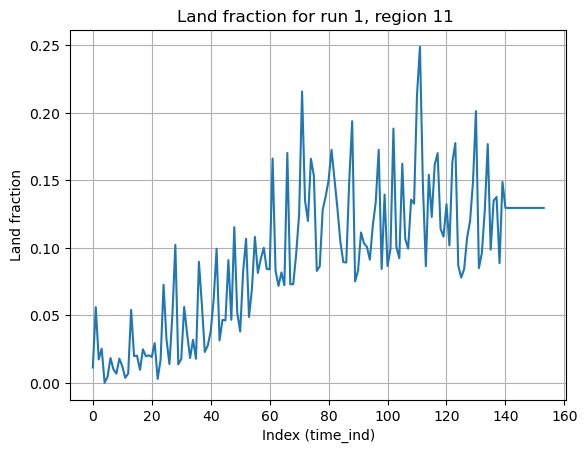

In [37]:
ages = np.arange(60,-1,-1)
age_ref = np.nanmax(ages)
year_ref = 2020
year_start = year_ref - age_ref
year_end = 2113 # based on maximum life expectancy reported in UNWPP
year_range = np.arange(year_start,year_end+1)

import matplotlib.pyplot as plt

da = ds_lfe_perregion_perrun['landfrac_peryear_perregion_RCP'].sel(run=1, region=11)

if np.all(np.isnan(da.values)):
    print("Warning: All values are NaN — nothing to plot.")
else:
    plt.plot(np.arange(len(year_range)), da.values)
    plt.xlabel("Index (time_ind)")
    plt.ylabel("Land fraction")
    plt.title("Land fraction for run 1, region 11 ")
    plt.grid()
    plt.show()

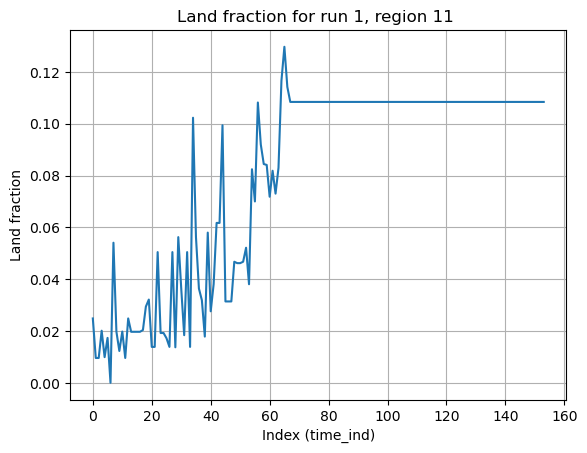

In [38]:
da = ds_lfe_perregion_perrun['landfrac_peryear_perregion_15'].sel(run=1, region=11)

if np.all(np.isnan(da.values)):
    print("Warning: All values are NaN — nothing to plot.")
else:
    plt.plot(np.arange(len(year_range)), da.values)
    plt.xlabel("Index (time_ind)")
    plt.ylabel("Land fraction")
    plt.title("Land fraction for run 1, region 11 ")
    plt.grid()
    plt.show()

ds_lfe_perregion

In [39]:
file_path = data_dir + '{}/{}/ds_lfe_perregion_gmt_{}.pkl'.format('pickles_v3','heatwavedarea','original')
with open(file_path, 'rb') as f: ds_lfe_perregion=pk.load(f)   

print(ds_lfe_perregion['mmm_15'].sel(region=1))

<xarray.DataArray 'mmm_15' (time_ind: 154)>
array([0.01860619, 0.01627185, 0.01009829, 0.01267751, 0.00591223,
       0.00790096, 0.0001454 , 0.02505688, 0.00864912, 0.01304839,
       0.00864912, 0.01009829, 0.01314123, 0.02214964, 0.02214964,
       0.02214964, 0.01675192, 0.02193422, 0.0274132 , 0.00502928,
       0.00974154, 0.00974154, 0.01688302, 0.02642659, 0.01903103,
       0.00177284, 0.00974154, 0.01669649, 0.01997234, 0.02249286,
       0.01435335, 0.01355109, 0.01688302, 0.0096903 , 0.02465152,
       0.02249286, 0.01435335, 0.04314353, 0.03563005, 0.01015129,
       0.01109433, 0.02654141, 0.03092952, 0.02017129, 0.01268809,
       0.01960403, 0.0213112 , 0.0213112 , 0.02135657, 0.02250228,
       0.02083798, 0.02675137, 0.03026572, 0.02330894, 0.02843271,
       0.02134539, 0.04702495, 0.04732064, 0.05167813, 0.04208168,
       0.05985994, 0.05383403, 0.04739585, 0.0567999 , 0.07721947,
       0.08924302, 0.09418342, 0.09724619, 0.08798739, 0.07665219,
       0.10464266,

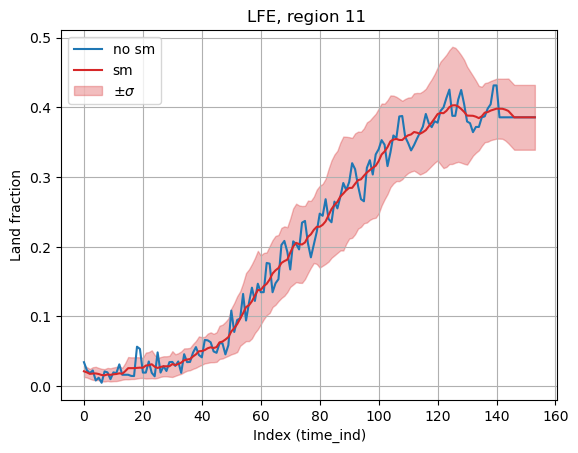

In [40]:
ds = ds_lfe_perregion['mmm_NDC'].sel(region=11)
ds_sm = ds_lfe_perregion['mmm_NDC_sm'].sel(region=11)
std_sm = ds_lfe_perregion['std_NDC_sm'].sel(region=11)
median_sm = ds_lfe_perregion['median_NDC_sm'].sel(region=11)

plt.plot(np.arange(len(year_range)), ds,label='no sm')
plt.plot(np.arange(len(year_range)), ds_sm,color='tab:red',label='sm')
plt.fill_between(np.arange(len(year_range)), ds_sm - std_sm, ds_sm + std_sm, alpha=0.3, label=r'$\pm \sigma$',color='tab:red',lw=1)
#plt.fill_between(np.arange(len(year_range)), ds_sm - median_sm, ds_sm + median_sm, alpha=0.3, label=r'$\pm \sigma$',color='tab:green',lw=1)
plt.xlabel("Index (time_ind)")
plt.ylabel("Land fraction")
plt.title("LFE, region 11 ")
plt.legend()
plt.grid()
plt.show()

ds_lfe_percountry

In [48]:
file_path = data_dir + '{}/{}/ds_lfe_percountry_gmt_{}.pkl'.format('pickles_v3','heatwavedarea','original')
with open(file_path, 'rb') as f: ds_lfe_percountry=pk.load(f)   

print(ds_lfe_percountry['mmm_20_sm'].sel(country='Belgium'))

<xarray.DataArray 'mmm_20_sm' (time_ind: 154)>
array([0.        , 0.        , 0.        , 0.00626843, 0.00557193,
       0.00501474, 0.00501474, 0.00501474, 0.00501474, 0.00501474,
       0.00501474, 0.00501474, 0.00501474, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.01428571, 0.04285714,
       0.04285714, 0.04285714, 0.04285714, 0.04285714, 0.04285714,
       0.04285714, 0.04285714, 0.04285714, 0.02857143, 0.        ,
       0.        , 0.        , 0.00927996, 0.02025536, 0.02025536,
       0.02943706, 0.02943706, 0.02943706, 0.02943706, 0.03695911,
       0.03695911, 0.03695911, 0.02767914, 0.01753355, 0.02754505,
       0.02256614, 0.02341386, 0.05198529, 0.07303467, 0.07894176,
       0.08144913, 0.09656464, 0.10834298, 0.10751319, 0.09750168,
       0.101659

In [50]:
file_path = data_dir + '{}/{}/ds_le_percountry_gmt_{}.pkl'.format('pickles_v3','heatwavedarea','original')
with open(file_path, 'rb') as f: ds_le_percountry=pk.load(f)   

print(ds_le_percountry['mmm_BE'].sel(country='Belgium'))

<xarray.DataArray 'mmm_BE' (birth_year: 61, GMT: 28)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    country     <U7 'Belgium'
  * birth_year  (birth_year) int64 1960 1961 1962 1963 ... 2017 2018 2019 2020
  * GMT         (GMT) int64 0 1 2 3 4 5 6 7 8 9 ... 19 20 21 22 23 24 25 26 27
    quantile    float64 0.25
